In [ ]:
!git clone https://github.com/anm-ol/DreamLab
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p DreamLab/data/video
!mkdir -p DreamLab/data/mario
!mkdir -p DreamLab/weights
!cp drive/MyDrive/data/videos/mario_gameplay.mp4 DreamLab/data/video/mario_gameplay.mp4
%cd DreamLab

In [93]:
from src.data import *
extract_frames('data/video/mario_gameplay.mp4', 400, 1400, 2, 'data/mario', size=(256, 256))
split_data2('data/mario', test_split=0.2, num_frames=1)

Total frames in video: 69878


In [7]:
from src.data import videoDataset
from torch.utils.data import DataLoader
dataset = videoDataset('data/mario', 'data/train.txt', (256, 256))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

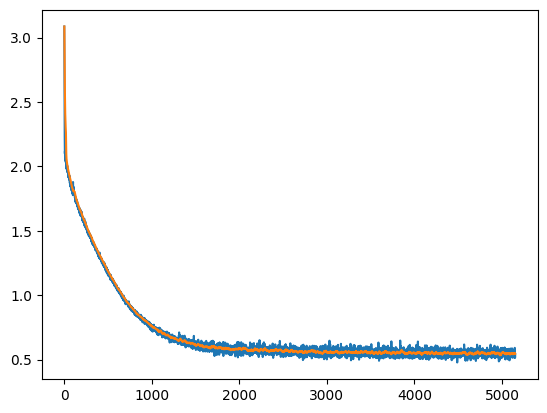

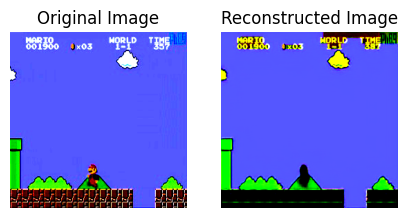

In [4]:
from src.autoencoder import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myvae = vae().to(device)
train(myvae, dataloader, dataset=dataset, lr=0.001, num_epochs=50)


In [4]:
autoencoder = myvae
dataset2 = dataset

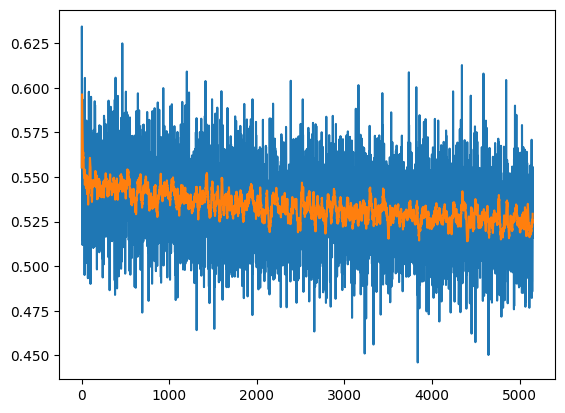

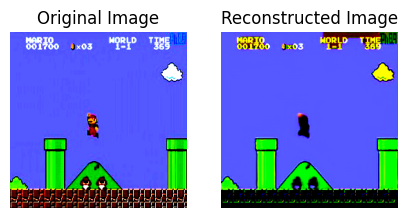

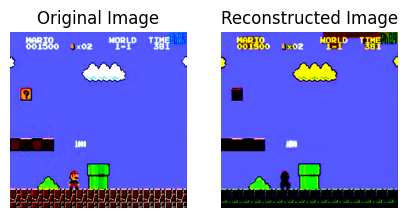

In [5]:
train(myvae, dataloader, lr=0.001, dataset=dataset, num_epochs=50)
sample_image(myvae, dataset, 0)

In [3]:
torch.save(myvae.state_dict(), 'weights/simplevae_weights.pth')
torch.save(dataset, 'weights/dataset.pth')


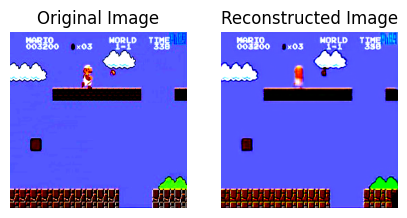

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.autoencoder import *
myvae = vae().to(device)
myvae.load_state_dict(torch.load('weights/simplevae_weights.pth'))
dataset = torch.load('weights/dataset.pth')
sample_image(myvae, dataset, 0)

In [68]:
import torch
import torch.nn as nn
import time
import numpy as np
from IPython.display import clear_output
from src.noise_scheduler import get_schedule, add_noise

def positional_encoding(t, dim, period=10000):
    emb = torch.zeros(1, dim)
    for i in range(0, dim, 2):
        emb[0, i] = np.sin(t / period ** ((i) / dim))
        emb[0, i + 1] = np.cos(t / period ** ((i) / dim))
        
    return torch.tensor(emb)


class patchify(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    def forward(self, x): #input shape: (B, C, W, H)
        batch_size, n_channels, self.width, self.height = x.size()
        self.C = n_channels
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # shape (B, C, W//P, H//P, P, P)
        patches = patches.contiguous().view(batch_size, n_channels, -1, self.patch_size, self.patch_size).permute(0, 2, 1, 3, 4)
        # shape (B, N, C, P, P)
        patches = patches.contiguous().view(batch_size, -1, n_channels * self.patch_size * self.patch_size)
        # shape (B, N, C*P*P)
        return patches

    def unpatchify(self, x): #input shape: (B, N, C*P*P)
        batch_size, num_patches, flattened_dim = x.size()
        patch_size = self.patch_size
        num_channels = self.C
        # Calculate grid dimensions
        grid_size = int(num_patches ** 0.5)
        # Reshape and permute
        x = x.view(batch_size, grid_size, grid_size, num_channels, patch_size, patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        # Combine patches
        x = x.view(batch_size, num_channels, grid_size * patch_size, grid_size * patch_size)
        return x
    
class DiT(nn.Module):
    def __init__(self, dims=512):
        super(DiT, self).__init__()
        self.patchify = patchify(4)
        self.embd = nn.Linear(512, dims)
        self.fc1 = nn.Linear(dims, dims)
        self.fc2 = nn.Linear(dims, dims)
        self.silu = nn.SiLU()
        self.dims = dims
        self.norm = nn.LayerNorm(dims)
        self.blocks = nn.ModuleList([DIT_block(dims) for _ in range(6)])
        self.linear = nn.Linear(dims, dims * 2)

    def forward(self, x, t): #input shape: (B, N, C, W, H)
        x = self.patchify(x)
        x = self.embd(x) 
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc2(x)
        # X shape: B, N, D
        spatial_embedding = [positional_encoding(i, self.dims)[0] for i in range(x.size(1))]
        spatial_embedding = torch.stack(spatial_embedding).unsqueeze(0).repeat(x.size(0), 1, 1).to(device)
        x = x + spatial_embedding

        noise_embedding = positional_encoding(t, self.dims).to(device).unsqueeze(0).repeat(x.size(0), 1, 1)
        x = torch.concat((x, noise_embedding), dim=1)
        for block in self.blocks:
            x = block(x)
        x = self.linear(x)
        x = x[:, :-1, :]
        x = x.contiguous()
        noise, var = torch.chunk(x, 2, dim=2)
        noise, var = self.patchify.unpatchify(noise), self.patchify.unpatchify(var)
        noise = (noise + torch.randn(var.size()).to(device) * var)
        return noise
    
class DIT_block(nn.Module):
    def __init__(self, dims):
        super(DIT_block, self).__init__()
        self.norm1 = nn.LayerNorm(dims)
        self.norm2 = nn.LayerNorm(dims)
        self.attn = nn.MultiheadAttention(dims, num_heads=4, batch_first=True)
        self.linear = nn.Linear(dims, dims)

    def forward(self, x):
        residue = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x += residue
        residue = x
        x = self.norm2(x)
        x = self.linear(x)
        x += residue
        return x

def train_denoiser(dit_model, vae, dataloader, num_steps=10, lr=0.0001, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dit_model.train()
    vae.eval()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(dit_model.parameters(), lr=lr)
    alphas = get_schedule(num_steps)
    losses = []
    losses_mean = []
    for epoch in range(num_epochs + 1):
        for i, input in enumerate(dataloader):
            input = input[:, 0].to(device)
            with torch.no_grad():
                input = vae.encoder(input)
                input = input / 3.6
            t = np.random.randint(0, num_steps - 1)
            alpha = torch.tensor(alphas[t])
            noised = add_noise(input, alpha).to(device)

            optimizer.zero_grad()
            loss = criterion(dit_model(noised, t), noised - input)
            losses.append(loss.item())
            loss_mean = torch.tensor(losses[-40:]).mean()
            losses_mean.append(loss_mean)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss_mean:.4f}')
        if epoch % 5 == 0:
            clear_output()
            plt.plot(losses)
            plt.plot(losses_mean)
            plt.show()

def diffusion_sampler(vae, dit_model, num_steps=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.eval()
    dit_model.eval()
    img = dataset[0][0].unsqueeze(0).to(device)
    latent = vae.encoder(img)
    latent = torch.randn(latent.size()).to(device)
    output = vae.decoder(latent)
    alphas_cum = torch.tensor(get_schedule(num_steps))
    plt.figure(figsize=(3, 3))
    plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    with torch.no_grad():
        for t in range(num_steps-1, -1, -1):
            alpha_t = alphas_cum[t]/alphas_cum[t-1] if t > 0 else alphas_cum[t]
            print(f'Step {t}, alpha: {alphas_cum[t]}')
            eps =  dit_model(latent, t)
            sigma_t = (1 - alpha_t) * (1 - alphas_cum[t-1]) / (1 - alphas_cum[t])
            sigma_t = sigma_t ** 0.5
            # denoise from z_t to z_0 but also add some noise to get z_(t-1)  [i think thats how it works] 
            latent = (latent - (eps * (1 - alpha_t)/torch.sqrt(1 - alphas_cum[t]))) / torch.sqrt(alpha_t) 
            if t == 0:
                latent = latent
            else:   
                z = torch.randn_like(latent).to(device) 
                latent = latent #+ sigma_t * z
            output = vae.decoder(latent * 0.025)
            output = torch.clamp(output, 0, 1)
            plt.figure(figsize=(3, 3))
            plt.imshow(output[0].permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

In [10]:
dit = DiT().to(device)

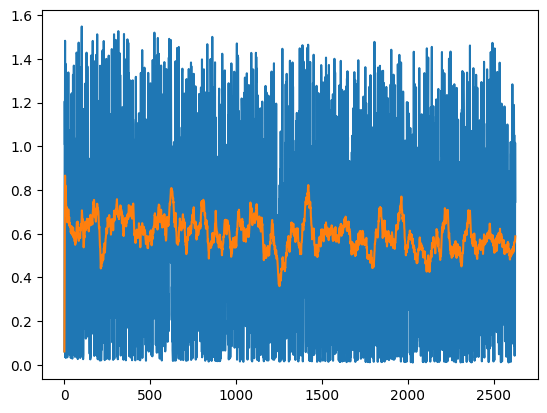

In [63]:
train_denoiser(dit, myvae, dataloader, num_steps=100, lr=1e-5, num_epochs=25)


In [22]:
torch.save(dit.state_dict(), 'weights/dit_weights_step100.pth')

In [28]:
randomz = myvae.encode(dataset[20].to(device))
torch.max(randomz), torch.min(randomz), torch.mean(randomz), torch.std(randomz)


(tensor(35.7039, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.1700, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.0876, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.7295, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
import matplotlib.pyplot as plt

# Flatten the tensor to 1D for histogram plotting
randomz_flat = randomz.cpu().detach().numpy().flatten()

# Plot the histogram
plt.hist(randomz_flat, bins=50, alpha=0.75)
plt.title('Histogram of randomz')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015053288..2.4193919].


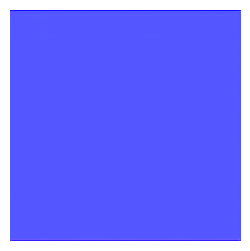

C:\Users\anmol\AppData\Local\Temp\ipykernel_2472\3943803008.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(emb)


Step 99, alpha: 2.052322629938552e-05


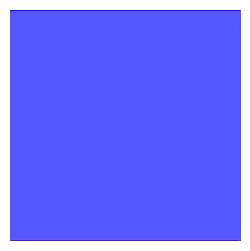

Step 98, alpha: 0.00041087629262936124


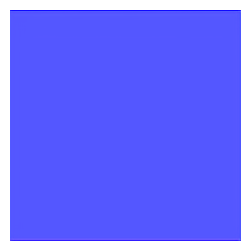

Step 97, alpha: 0.0012963519889026187


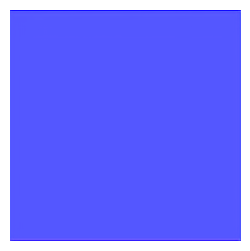

Step 96, alpha: 0.002676072811191756


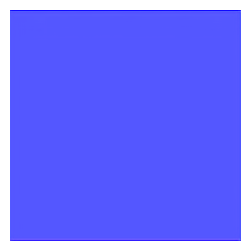

Step 95, alpha: 0.004548671460037921


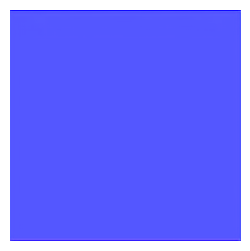

Step 94, alpha: 0.0069122921954407794


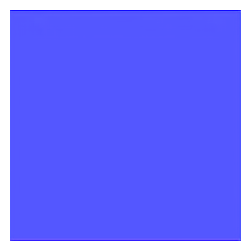

Step 93, alpha: 0.009764592675891885


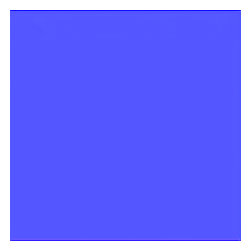

Step 92, alpha: 0.013102746279627996


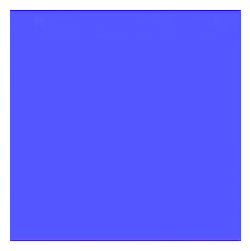

Step 91, alpha: 0.016923444905805846


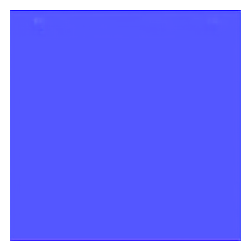

Step 90, alpha: 0.02122290225282034


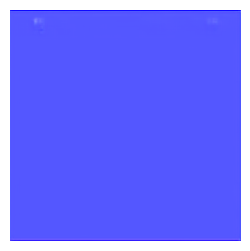

Step 89, alpha: 0.025996857570519113


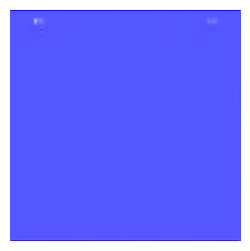

Step 88, alpha: 0.031240579882594034


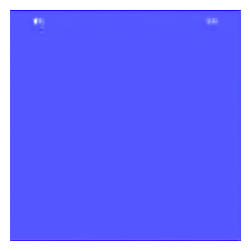

Step 87, alpha: 0.03694887267496504


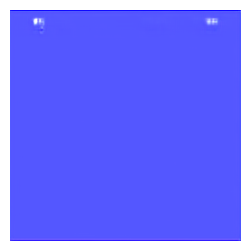

Step 86, alpha: 0.043116079045511436


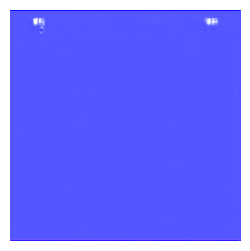

Step 85, alpha: 0.04973608731004536


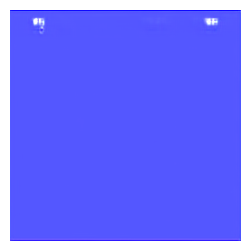

Step 84, alpha: 0.056802337058974764


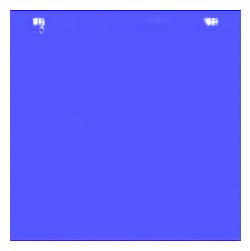

Step 83, alpha: 0.06430782565864951


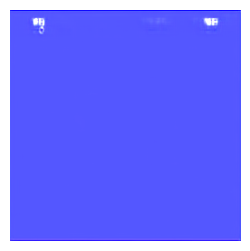

Step 82, alpha: 0.07224511519095274


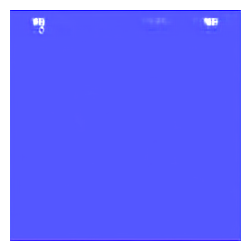

Step 81, alpha: 0.08060633982425618


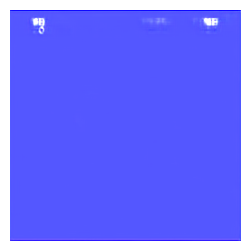

Step 80, alpha: 0.08938321360843782


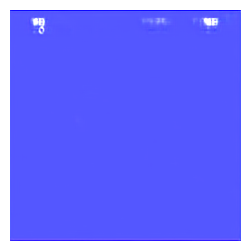

Step 79, alpha: 0.09856703868623458


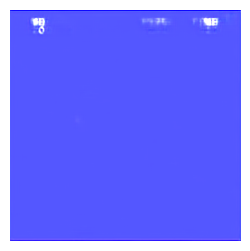

Step 78, alpha: 0.10814871391279447


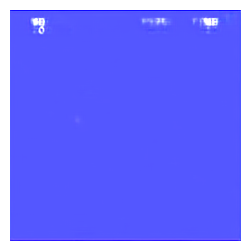

Step 77, alpha: 0.11811874387488601


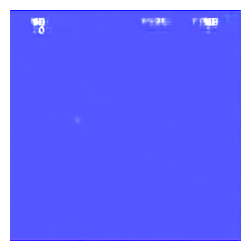

Step 76, alpha: 0.12846724830082573


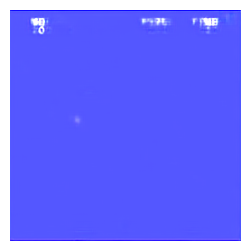

Step 75, alpha: 0.13918397185179987


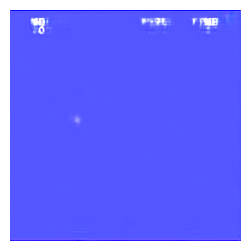

Step 74, alpha: 0.15025829428487605


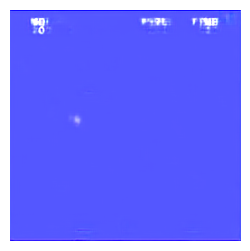

Step 73, alpha: 0.16167924097763428


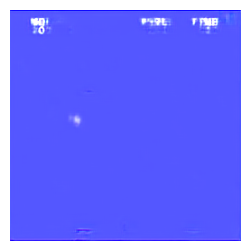

Step 72, alpha: 0.17343549380398757


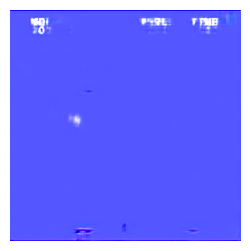

Step 71, alpha: 0.1855154023504116


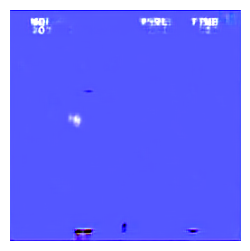

Step 70, alpha: 0.1979069954614733


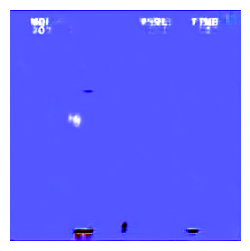

Step 69, alpha: 0.2105979931032116


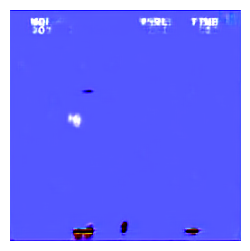

Step 68, alpha: 0.22357581853261643


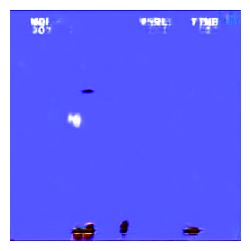

Step 67, alpha: 0.23682761076114658


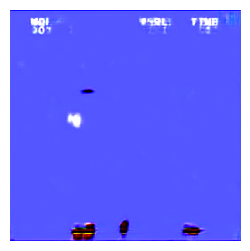

Step 66, alpha: 0.25034023729993166


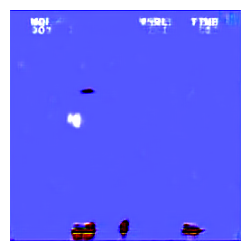

Step 65, alpha: 0.26410030717403304


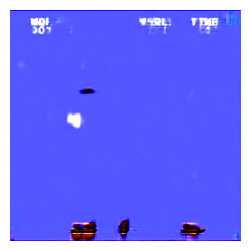

Step 64, alpha: 0.2780941841928621


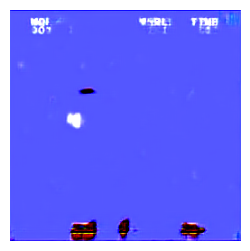

Step 63, alpha: 0.2923080004636061


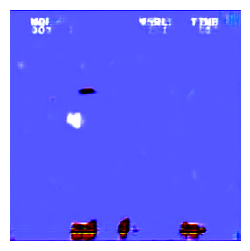

Step 62, alpha: 0.30672767013427243


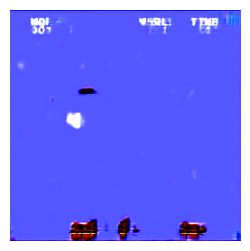

Step 61, alpha: 0.3213389033527264


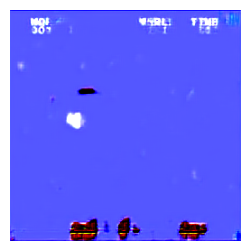

Step 60, alpha: 0.3361272204278966


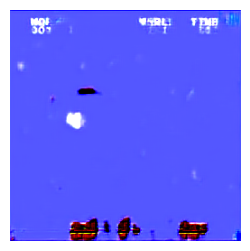

Step 59, alpha: 0.3510779661791061


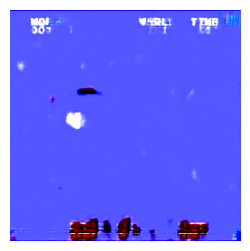

Step 58, alpha: 0.3661763244593174


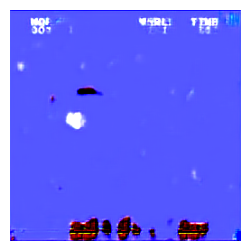

Step 57, alpha: 0.38140733283789036


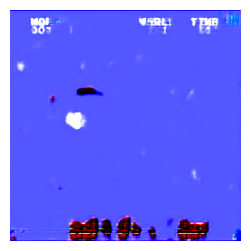

Step 56, alpha: 0.396755897428311


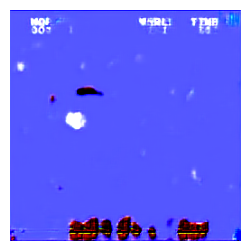

Step 55, alpha: 0.4122068078461893


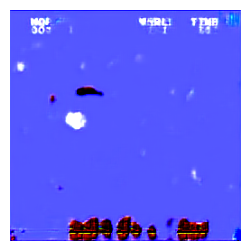

Step 54, alpha: 0.4277447522827073


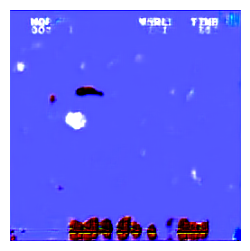

Step 53, alpha: 0.4433543326785798


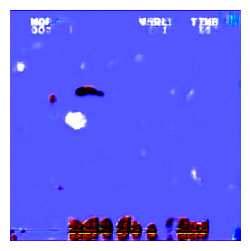

Step 52, alpha: 0.45902007998348643


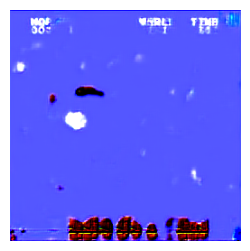

Step 51, alpha: 0.47472646948585845


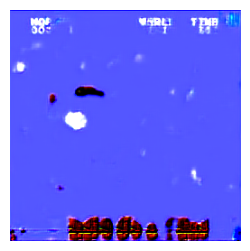

Step 50, alpha: 0.49045793619782313


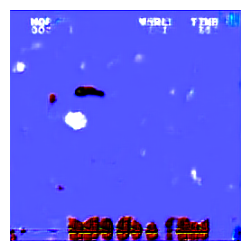

Step 49, alpha: 0.5061988902800636


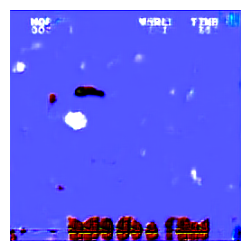

Step 48, alpha: 0.5219337324913059


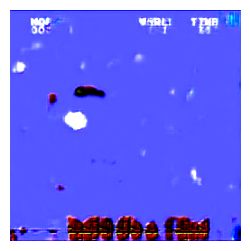

Step 47, alpha: 0.5376468696471225


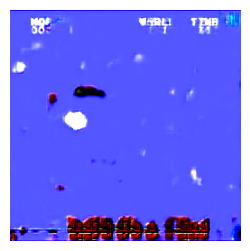

Step 46, alpha: 0.5533227300727357


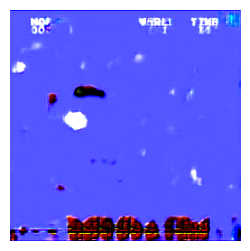

Step 45, alpha: 0.5689457790345019


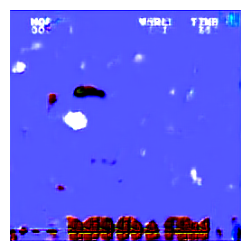

Step 44, alpha: 0.58450053413479


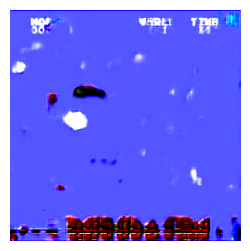

Step 43, alpha: 0.5999715806549942


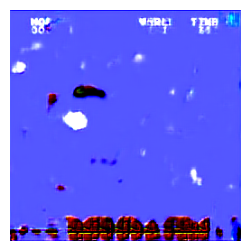

Step 42, alpha: 0.6153435868314759


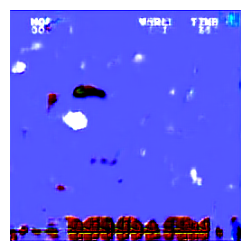

Step 41, alpha: 0.6306013190492991


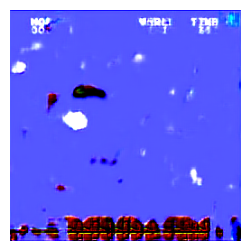

Step 40, alpha: 0.6457296569386998


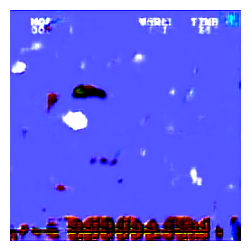

Step 39, alpha: 0.66071360835933


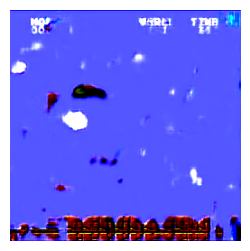

Step 38, alpha: 0.6755383242574264


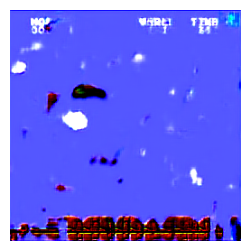

Step 37, alpha: 0.6901891133811815


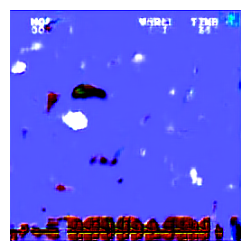

Step 36, alpha: 0.7046514568397324


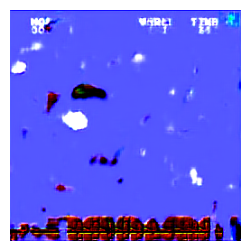

Step 35, alpha: 0.7189110224913408


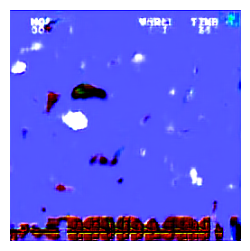

Step 34, alpha: 0.7329536791465058


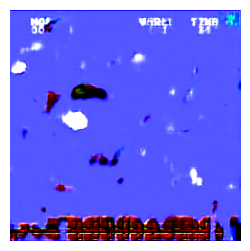

Step 33, alpha: 0.7467655105719325


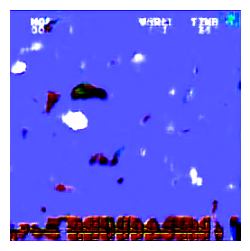

Step 32, alpha: 0.7603328292814802


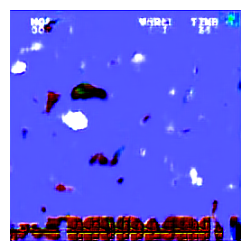

Step 31, alpha: 0.7736421901004221


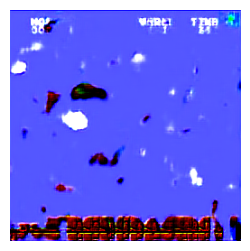

Step 30, alpha: 0.7866804034895776


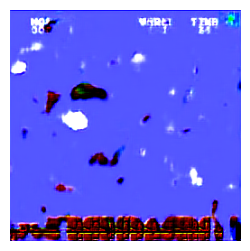

Step 29, alpha: 0.7994345486161061


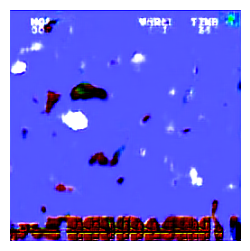

Step 28, alpha: 0.8118919861580177


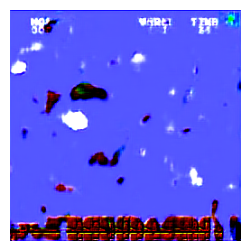

Step 27, alpha: 0.8240403708297059


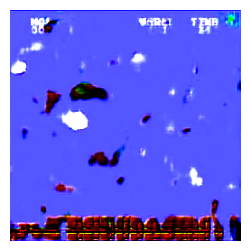

Step 26, alpha: 0.8358676636160888


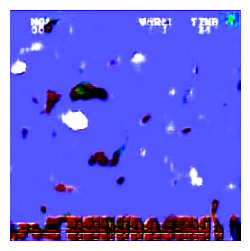

Step 25, alpha: 0.8473621437032424


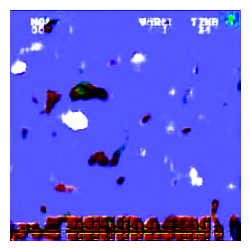

Step 24, alpha: 0.8585124200936916


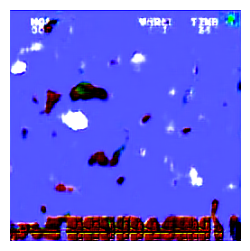

Step 23, alpha: 0.8693074428948584


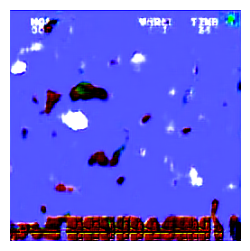

Step 22, alpha: 0.8797365142694734


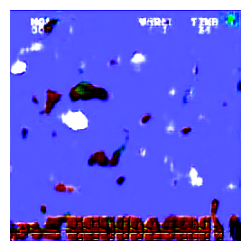

Step 21, alpha: 0.8897892990371031


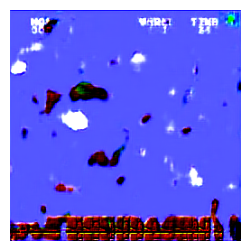

Step 20, alpha: 0.8994558349162841


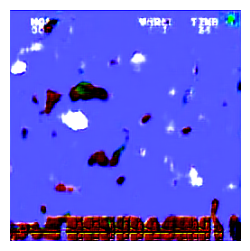

Step 19, alpha: 0.9087265423971165


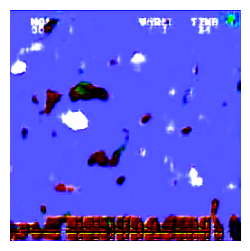

Step 18, alpha: 0.9175922342345313


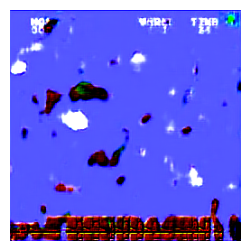

Step 17, alpha: 0.9260441245528241


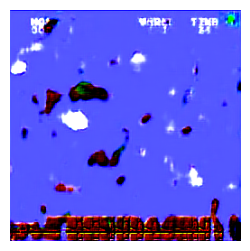

Step 16, alpha: 0.9340738375524333


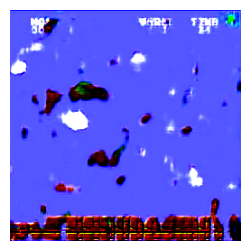

Step 15, alpha: 0.9416734158103347


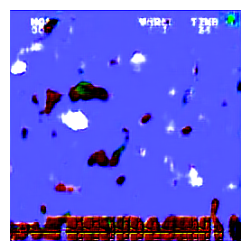

Step 14, alpha: 0.9488353281658243


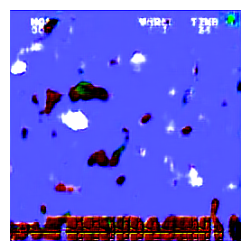

Step 13, alpha: 0.9555524771838778


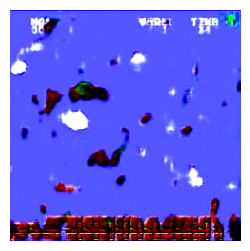

Step 12, alpha: 0.961818206188689


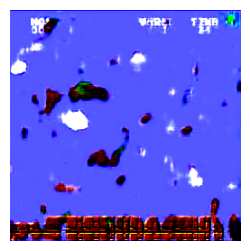

Step 11, alpha: 0.9676263058604164


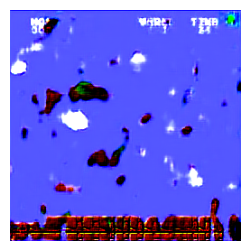

Step 10, alpha: 0.9729710203886022


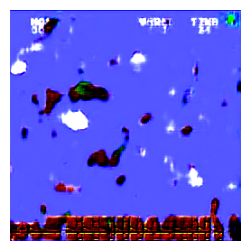

Step 9, alpha: 0.9778470531761639


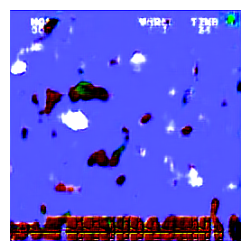

Step 8, alpha: 0.9822495720883078


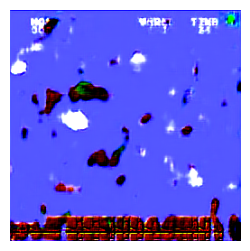

Step 7, alpha: 0.9861742142411595


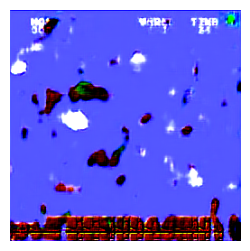

Step 6, alpha: 0.9896170903253714


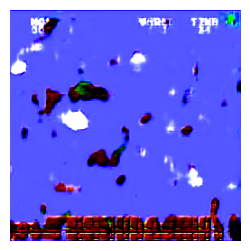

Step 5, alpha: 0.9925747884604161


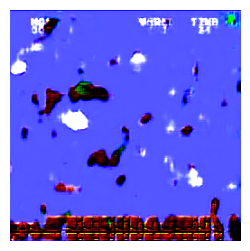

Step 4, alpha: 0.9950443775757507


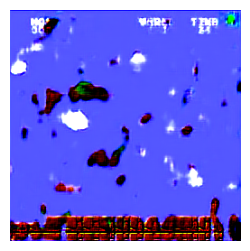

Step 3, alpha: 0.9970234103155001


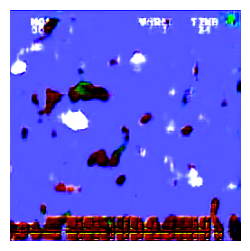

Step 2, alpha: 0.9985099254637787


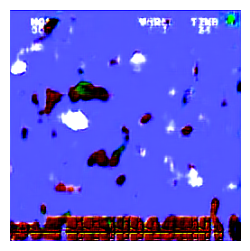

Step 1, alpha: 0.9995024498882508


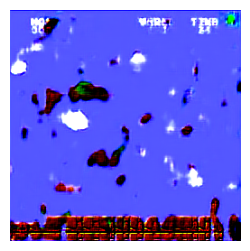

Step 0, alpha: 1.0


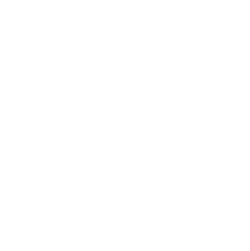

In [69]:
diffusion_sampler(myvae, dit, num_steps=100)